# Analysing factors affecting size class of fire

##### Import necessary packages

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
# !pip install ReliefF
# from ReliefF import ReliefF
!pip install sklearn-relief
import sklearn_relief as relief

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
# read the data from CSV file
us_wildfire = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/FW_Veg_Rem_Combined.csv")
us_wildfire.head()

,Unnamed: 0,Unnamed: 0.1,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,cont_clean_date,discovery_month,disc_date_final,cont_date_final,putout_time,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,Vegetation,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,0,0,NaN,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,NaN,Feb,NaN,NaN,NaN,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,12,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,1,1,NaN,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,NaN,Dec,NaN,NaN,NaN,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,15,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,2,2,NaN,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,NaN,Feb,NaN,NaN,NaN,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,16,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,3,3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,6/6/2005,Jun,6/6/2005 2:14,6/6/2005 18:00,0 days 00:00:00.000000000,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,4,4,NaN,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,NaN,Sep,NaN,NaN,NaN,8/23/1999,1999,Aug,722312,25940.57409,3908,1987,2016,12,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633


In [16]:
# Remove unnecessary columns from the dataset
dropColumns = ["Unnamed: 0", "Unnamed: 0.1", "fire_name", "state", "discovery_month", "disc_date_final", "disc_clean_date",
               "cont_clean_date", "cont_date_final", "putout_time", "disc_date_pre", "disc_pre_year", "disc_pre_month",
               "fire_mag", "wstation_usaf", "dstation_m", "wstation_wban", "wstation_byear",
               "wstation_eyear", "weather_file"]
us_wildfire_clean = us_wildfire.drop(columns=dropColumns)
# Add column fire_cause as numeric column

cause_dict = {"Arson": 1, "Campfire": 2, "Children": 3, "Debris Burning": 4, "Equipment Use": 5, 
              "Fireworks": 6, "Lightning": 7, "Miscellaneous": 8, "Missing/Undefined": 9, 
              "Powerline": 10, "Railroad": 11, "Smoking": 12, "Structure": 13}

us_wildfire_clean["Fire_cause"] = us_wildfire_clean["stat_cause_descr"].map(cause_dict).fillna(value=9)
# Add new column for vegetation description
veg_dict = {1: "Tropical Evergreen Broadleaf Forest", 2: "Tropical Deciduous Broadleaf Forest",
            3: "Temperate Evergreen Broadleaf Forest", 4: "Temperate Evergreen Needleleaf Forest",
            5: "Temperate Deciduous Broadleaf Forest", 6: "Boreal Evergreen Needleleaf Forest",
            7: "Boreal Deciduous Needleleaf Forest", 8: "Savanna", 9: "C3 Grassland/Steppe",
            10: "C4 Grassland/Steppe", 11: "Dense Shrubland", 12: "Open Shrubland", 13: "Tundra Tundra",
            14: "Desert", 15: "Polar Desert/Rock/Ice", 16: "Secondary Tropical Evergreen Broadleaf Forest",
            17: "Secondary Tropical Deciduous Broadleaf Forest", 18: "Secondary Temperate Evergreen Broadleaf Forest",
            19: "Secondary Temperate Evergreen Needleleaf Forest"
            }

us_wildfire_clean["Veg_Descr"] = us_wildfire_clean["Vegetation"].map(veg_dict).fillna(value="Unknown")

# Convert temperature from Celcius to Fahrenheit
us_wildfire_clean["Temp_pre_30"] = (us_wildfire_clean["Temp_pre_30"] * 9 / 5) + 32
us_wildfire_clean["Temp_pre_15"] = (us_wildfire_clean["Temp_pre_15"] * 9 / 5) + 32
us_wildfire_clean["Temp_pre_7"] = (us_wildfire_clean["Temp_pre_7"] * 9 / 5) + 32
us_wildfire_clean["Temp_cont"] = (us_wildfire_clean["Temp_cont"] * 9 / 5) + 32

us_wildfire_clean.head()

,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Fire_cause,Veg_Descr
0,10.0,C,Missing/Undefined,18.105072,-66.753044,12,76.065753,76.490462,76.824675,76.150329,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,9,Open Shrubland
1,3.0,B,Arson,35.038330,-87.610000,15,45.596180,44.618000,32.618353,50.806936,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,1,Polar Desert/Rock/Ice
2,60.0,C,Arson,34.947800,-88.722500,16,40.949474,42.408979,42.005750,56.653880,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,1,Secondary Tropical Evergreen Broadleaf Forest
3,1.0,B,Debris Burning,39.641400,-119.308300,0,61.296741,66.193126,64.656615,32.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447,4,Unknown
4,2.0,B,Miscellaneous,30.700600,-90.591400,12,30.200000,30.200000,30.200000,30.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633,8,Open Shrubland


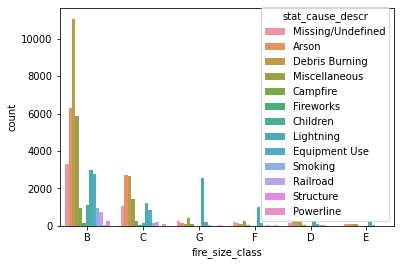

In [4]:
## Visualize data for fire size classes
sns.countplot(data=us_wildfire_clean, x="fire_size_class", hue="stat_cause_descr",
              order=us_wildfire_clean["fire_size_class"].value_counts().index)

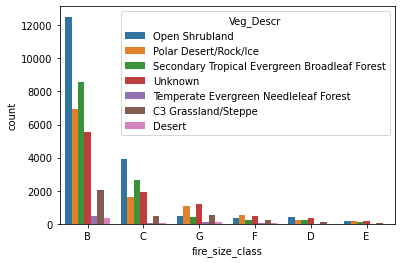

In [18]:
## Visualize vegetation for class
sns.countplot(data=us_wildfire_clean, x="fire_size_class", hue="Veg_Descr",
              order=us_wildfire_clean["fire_size_class"].value_counts().index)

In [5]:
us_wildfire_clean = us_wildfire_clean.drop(columns=['stat_cause_descr'])
classCount = us_wildfire.groupby('fire_size_class').count()[['Unnamed: 0.1']]
classCount


,Unnamed: 0.1
fire_size_class,
B,36522
C,10811
D,1394
E,700
F,1968
G,3972


In [6]:
us_wildfire_clean.tail()

,fire_size,fire_size_class,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Fire_cause
55362,6289.0,G,39.180000,-96.784167,0,67.497438,62.404308,66.054190,55.836183,3.259176,2.705398,3.196648,3.804803,65.671410,61.839572,54.625698,55.042092,35.4,8.2,0.0,249.0,0.331501,9
55363,70868.0,G,38.342719,-120.695967,0,30.200000,30.200000,30.200000,30.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.124683,9
55364,5702.0,G,37.262607,-119.511139,0,83.165726,83.165726,82.700000,81.762921,2.649395,2.649395,2.667722,2.529158,43.755556,43.755556,44.443975,35.924406,0.0,0.0,0.0,0.0,0.097682,1
55365,3261.0,F,40.604300,-123.080450,15,30.200000,30.200000,30.200000,30.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.178206,8
55366,76067.0,G,38.843988,-122.759707,0,70.862404,70.362500,71.533571,66.230390,1.795485,1.628065,1.036905,1.208073,50.521912,46.310627,37.178571,58.063802,0.3,0.3,0.0,18.8,0.167305,9


In [7]:
# Feature Selection
# split the data in training and testing sets.
 
trainSet, testSet = train_test_split(us_wildfire_clean, train_size = 0.80, stratify = us_wildfire_clean["fire_size_class"])
# featureCols = ["fire_size", "latitude", "longitude", "Temp_pre_30", "Wind_pre_30", "Hum_pre_30","Prec_pre_30", "remoteness"]
cols = ['latitude', 'longitude', 'Vegetation',
       'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'Temp_cont', 'Wind_pre_30',
       'Wind_pre_15', 'Wind_pre_7', 'Wind_cont', 'Hum_pre_30', 'Hum_pre_15',
       'Hum_pre_7', 'Hum_cont', 'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7',
       'Prec_cont', 'remoteness', 'Fire_cause']

X = trainSet[cols].values
y_train = trainSet[["fire_size_class"]].values.ravel()

X1 = testSet[cols].values
y_test = testSet[["fire_size_class"]].values.ravel()

print(y_test)

['B' 'B' 'C' ... 'B' 'B' 'B']


In [8]:
fs = relief.ReliefF(k=30, n_features=10)
fsRelief = fs.fit_transform(X, y_train)
print(fs.w_)
#X_train=fsRelief.transform(X)
#X_test=fsRelief.transform(X1)
#print("(No. of tuples, No. of Columns before ReliefF) : "+str(featureDataSet.shape)+
#     "\n(No. of tuples, No. of Columns after ReliefF) : "+str(selectedFeatures.shape))


[424.34526073 424.34526073 424.34526073 424.34526073 424.34526073
 424.34526073 424.34526073 424.34526073 424.34526073 424.34526073
 424.34526073 424.34526073 424.34526073 424.34526073 424.34526073
 424.34526073 424.34526073 424.34526073 424.34526073 424.34526073
 424.34526073]


#### Data Sampling
Split the data into training set and testing set

In [10]:
trainSet, testSet = train_test_split(us_wildfire_clean, train_size = 0.80, stratify = us_wildfire_clean["fire_size_class"])
print("#### Data point per each class in whole dataset")
print(us_wildfire_clean.groupby(["fire_size_class"])[["fire_size_class"]].count())
print(" ")
print("### Data point per each class in training dataset")
print(trainSet.groupby(["fire_size_class"])[["fire_size_class"]].count())
print(" ")
print("### Data point per each class in test dataset")
print(testSet.groupby(["fire_size_class"])[["fire_size_class"]].count())
kfold = KFold(n_splits=10, random_state=None, shuffle=False)

#### Data point per each class in whole dataset
                 fire_size_class
fire_size_class                 
B                          36522
C                          10811
D                           1394
E                            700
F                           1968
G                           3972
 
### Data point per each class in training dataset
                 fire_size_class
fire_size_class                 
B                          29217
C                           8649
D                           1115
E                            560
F                           1574
G                           3178
 
### Data point per each class in test dataset
                 fire_size_class
fire_size_class                 
B                           7305
C                           2162
D                            279
E                            140
F                            394
G                            794


In [19]:
# Taken only weighted features from training and test set that too give greater correlations with target class
selected_cols = ["latitude", "longitude", "Temp_pre_30", "Wind_pre_30", "Hum_pre_30","Prec_pre_30", "remoteness"]
X = trainSet[selected_cols].values
y_train = trainSet[["fire_size_class"]].values.ravel()

X1 = testSet[selected_cols].values
y_test = testSet[["fire_size_class"]].values.ravel()

# Data standardization
sc = StandardScaler().fit(X)
X_train = sc.transform(X)

sc = StandardScaler().fit(X1)
X_test = sc.transform(X1)


In [12]:
# Report Unique data points per size class of fire in the training set
unique, count = np.unique(y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{'B': 29217, 'C': 8649, 'D': 1115, 'E': 560, 'F': 1574, 'G': 3178}

In [ ]:
# Try SMOTE sampling on the data to remove target class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

sm = SMOTE("not majority")
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
unique, count = np.unique(y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

{'B': 29217, 'C': 29217, 'D': 29217, 'E': 29217, 'F': 29217, 'G': 29217}

Text(0, 0.5, 'Error Rate')

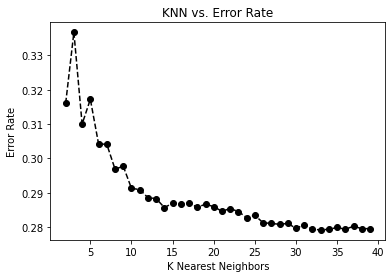

In [ ]:
### Compute error rate and plot it
error_rate = []
for k in range(2,40,1):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    predictY = knn_classifier.predict(X_test)
    error_rate.append(np.mean(predictY != y_test))

ax = plt.gca()
ax = plt.gca()
plt.plot(range(2, 40, 1), error_rate, linestyle = "dashed", color = "black", marker = "o")
plt.title("KNN vs. Error Rate")
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Error Rate")

In [ ]:
### Implement KNN using optimal k-Value obtained from the graph (optimal value)
knn_classifier = KNeighborsClassifier(n_neighbors = 33)
knn_classifier.fit(X_train, y_train)
results = cross_val_score(knn_classifier, X_train, y_train, cv=kfold) #Cross validation on training set
print(results)

[0.7214447  0.72099323 0.71693002 0.71731768 0.72612328 0.72047866
 0.72115602 0.71054414 0.71370513 0.7272522 ]


In [ ]:
predict_y = knn_classifier.predict(X_test)
cr = classification_report(y_test, predict_y)
print("Classification Report KNN:")
print(cr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report KNN:
              precision    recall  f1-score   support

           B       0.73      0.99      0.84      7305
           C       0.38      0.02      0.05      2162
           D       0.00      0.00      0.00       279
           E       0.00      0.00      0.00       140
           F       0.50      0.05      0.09       394
           G       0.71      0.85      0.77       794

    accuracy                           0.72     11074
   macro avg       0.39      0.32      0.29     11074
weighted avg       0.62      0.72      0.62     11074



In [ ]:
cm = confusion_matrix(y_test, predict_y)
print("Confusion Matrix for KNN:")
print(cm)

Confusion Matrix for KNN:
[[7236   63    0    0    0    6]
 [2106   53    0    0    0    3]
 [ 270    9    0    0    0    0]
 [ 135    4    0    0    0    1]
 [ 107    5    0    0   20  262]
 [  93    7    0    0   20  674]]


##### Implement SVM Model

In [20]:
# SVM Model with default hyperparameters
default_svm = SVC(kernel='rbf')
kfold = KFold(n_splits=10, random_state=None, shuffle=False)
results = cross_val_score(default_svm, X, y_train, cv=kfold)

print(results)

[0.66659142 0.65643341 0.6765237  0.6671935  0.68119214 0.67238654
 0.68096636 0.66222624 0.67238654 0.66854821]


In [ ]:
default_svm.fit(X, y)
s_predict = default_svm.predict(X1)
cr = classification_report(y_test, s_predict)
print("Classification Report for SVM (default):")
print(cr)

In [ ]:
svm_classifier = SVC(kernel='rbf', C=1000, gamma=0.0001)
# svm_classifier.fit(X_train,y_train)
kfold = KFold(n_splits=10, random_state=42, shuffle=False)
results = cross_val_score(svm_classifier, X_train, y_train, cv=kfold) #Cross validation on training set

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print (results) #array_output


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.71264108 0.71422122 0.70835214 0.70602845 0.71054414 0.71393091
 0.71415669 0.7037706  0.7037706  0.71347934]


In [ ]:
svm_classifier.fit(X_train, y_train)
svm_predict = svm_classifier.predict(X_test)
cr = classification_report(y_test, svm_predict)
print("Classification Report for SVM:")
print(cr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SVM:
              precision    recall  f1-score   support

           B       0.71      1.00      0.83      7305
           C       0.00      0.00      0.00      2162
           D       0.00      0.00      0.00       279
           E       0.00      0.00      0.00       140
           F       0.00      0.00      0.00       394
           G       0.73      0.70      0.71       794

    accuracy                           0.71     11074
   macro avg       0.24      0.28      0.26     11074
weighted avg       0.52      0.71      0.60     11074



In [ ]:
cm = confusion_matrix(y_test, svm_predict)
print("Confusion Matrix for SVM:")
print(cm)

Confusion Matrix for SVM:
[[7305    0    0    0    0    0]
 [2162    0    0    0    0    0]
 [ 279    0    0    0    0    0]
 [ 140    0    0    0    0    0]
 [ 187    0    0    0    0  207]
 [ 239    0    0    0    0  555]]
